In [6]:
# =============================================================================
#   paint_ds: Definición de funciones modulares para todo el flujo
# =============================================================================

# 1) Imports y configuración global
%load_ext autoreload
%autoreload 2

import sys, os, json, argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Añade rutas de tu proyecto
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)
sys.path.append(os.path.abspath("../scripts"))
sys.path.append(os.path.abspath("../"))

# Desactivar LaTeX por defecto (evita errores si no está instalado)
plt.rcParams['text.usetex'] = False

# Tus componentes
from scripts.model import MILModel, AttentionMechanism
from data.datasets.SCStandardMILDataset import SCStandardMILDataset
from data.datasets.MCStandardMILDataset import MCStandardMILDataset
from data.datasets.MCStandard_MIO import MCStandard_MIO
from data.datasets.FalseFrequencyMILDataset import FalseFrequencyMILDataset

# 2) Dataset & DataLoader
def make_dataloaders(dataset_cls, D, num_bags, B, batch_size=1):
    """Crea train/test loaders para un SC-like Dataset."""
    train_ds = dataset_cls(D=D, num_bags=num_bags, B=B, train=True)
    test_ds  = dataset_cls(D=D, num_bags=num_bags, B=B, train=False)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              collate_fn=train_ds.collate_fn)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                              collate_fn=test_ds.collate_fn)
    return train_loader, test_loader

# 3) Entrenamiento
def train_mil_model(train_loader, feature_dim, pooling, lr, epochs, save_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MILModel(input_feature_dim=feature_dim, pooling_type=pooling).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        model.train()
        tot = 0
        for X, Y, _, adj, mask in train_loader:
            X, Y, mask = X.to(device), Y.float().unsqueeze(1).to(device), mask.to(device)
            logits, _ = model(X, mask=mask)
            loss = criterion(torch.sigmoid(logits), Y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            tot += loss.item()
        print(f"Epoch {ep}/{epochs} — Loss: {tot/len(train_loader):.4f}")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print("Modelo guardado en", save_path)
    return model

# 4) Evaluación
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix

def evaluate_mil_model(model, test_loader):
    device = next(model.parameters()).device
    model.eval()
    ys, ps, preds = [], [], []
    with torch.no_grad():
        for X, Y, _, adj, mask in test_loader:
            X, Y, mask = X.to(device), Y.to(device), mask.to(device)
            logits, _ = model(X, mask=mask)
            prob = torch.sigmoid(logits).item()
            pred = int(prob>0.5)
            ys.append(int(Y.item())); ps.append(prob); preds.append(pred)
    acc = accuracy_score(ys, preds)
    auc = roc_auc_score(ys, ps)
    f1  = f1_score(ys, preds)
    cm  = confusion_matrix(ys, preds)
    print(f"Acc: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")
    print("CM:\n", cm)

# 5) OOD scorers
def msp_score(model, x, mask):
    model.eval()
    with torch.no_grad():
        logits, _ = model(x, mask=mask)
        p = torch.sigmoid(logits)
        p_max = torch.max(torch.cat([p, 1-p], dim=1), dim=1).values
    return (1-p_max).cpu().numpy()

def energy_score(model, x, mask, T=1.0):
    model.eval()
    with torch.no_grad():
        logits, _ = model(x, mask=mask)
        e = -T * torch.logsumexp(logits/T, dim=1)
    return e.cpu().numpy()

def get_model_ood_scorers():
    return {"MSP": msp_score, "Energy": energy_score}

def compute_ood_scores(model, test_loader):
    device = next(model.parameters()).device
    scorers = get_model_ood_scorers()
    scores = {k: [] for k in scorers}
    with torch.no_grad():
        for X, Y, _, adj, mask in test_loader:
            X, mask = X.to(device), mask.to(device)
            for name, fn in scorers.items():
                sc = fn(model, X, mask)
                scores[name].extend(sc.tolist())
    for name, vals in scores.items():
        print(f"{name}: mean={np.mean(vals):.4f}, std={np.std(vals):.4f}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:

# 6) Visualización atención y bolsas
def get_first_positive(loader, device):
    for X,Y,y_inst,adj,mask in loader:
        if Y.item()==1:
            return X.to(device), y_inst.to(device), mask.to(device)
    raise RuntimeError("Sin bolsa positiva")

def plot_positive_bag_attention(loader, model, device, dims=(0,1)):
    """
    Visualiza la primera bolsa positiva del `loader`, coloreando las instancias por su atención,
    y dibuja la representación de la bolsa como un punto dorado.
    """

    import matplotlib.pyplot as plt
    import matplotlib as mpl
    mpl.rcParams['text.usetex'] = False  # Por si no tienes LaTeX
    import torch

    # Buscar la primera bolsa positiva
    for X_batch, Y_batch, _, _, mask_batch in loader:
        if Y_batch.item() == 1:
            X_pos, mask_pos = X_batch.to(device), mask_batch.to(device)
            break

    # Forward
    model.eval()
    with torch.no_grad():
        logits, attn_weights = model(X_pos, mask=mask_pos)
        features = X_pos  # características ya preextraídas
        bag_repr = torch.bmm(attn_weights.unsqueeze(1), features).squeeze(1)

    # Convertir a numpy
    X_np    = X_pos.squeeze(0).cpu().numpy()
    Z_np    = bag_repr.squeeze(0).cpu().numpy()
    att_np  = attn_weights.squeeze(0).cpu().numpy()

    # Gráfico
    plt.figure(figsize=(7,6))
    scatter = plt.scatter(
        X_np[:,dims[0]], X_np[:,dims[1]],
        c=att_np, cmap='Reds', s=60, edgecolors='k',
        label='Instancias (coloreadas por atención)'
    )
    plt.colorbar(scatter, label='Peso de atención')
    plt.scatter(
        Z_np[dims[0]], Z_np[dims[1]],
        c='gold', edgecolors='k', s=200,
        label='Representación de la bolsa'
    )

    plt.title("Visualización de una bolsa positiva con pesos de atención")
    plt.xlabel(f"Dimensión {dims[0]}")
    plt.ylabel(f"Dimensión {dims[1]}")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

def plot_attention_trajectories(loader, model, device, lambdas=None, dims=(0,1)):
    """
    Para la primera bolsa positiva, varía cada λ en `lambdas`,
    y dibuja las representaciones Z (dims) resultantes, con leyenda.
    """
    if lambdas is None:
        lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 5, 10]
    
    X, _, mask = get_first_positive(loader, device)
    X_np = X.squeeze(0).cpu().numpy()
    
    plt.figure(figsize=(6,6))
    # Plot de instancias
    plt.scatter(
        X_np[:,dims[0]], X_np[:,dims[1]],
        c='lightgray', edgecolors='k', alpha=0.7,
        label='Instancias'
    )

    # Guardamos el forward original
    orig_forward = model.attention.forward

    # Para cada λ, parcheamos, calculamos Z y ploteamos
    for lamb in lambdas:
        def scaled_forward(self, features, mask=None, _l=lamb):
            scores = self.attention_layer(features).squeeze(-1)
            if mask is not None:
                scores = scores.masked_fill(~mask.bool(), float('-inf'))
            scores = scores * _l
            weights = F.softmax(scores, dim=1)
            bag = torch.bmm(weights.unsqueeze(1), features).squeeze(1)
            return bag, weights

        # Monkey-patch
        model.attention.forward = scaled_forward.__get__(model.attention, type(model.attention))

        # Forward para Z
        model.eval()
        with torch.no_grad():
            Z, _ = model.attention(X.to(device), mask=mask)
            z = Z.squeeze(0).cpu().numpy()

        # Plot Z
        plt.scatter(
            z[dims[0]], z[dims[1]],
            edgecolors='k', s=50,
            label=f"λ = {lamb:g}"
        )

    # Restaurar forward original
    model.attention.forward = orig_forward

    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.title("Evolución de la representación de bolsa al variar λ")
    plt.xlabel(f"Dimensión {dims[0]}")
    plt.ylabel(f"Dimensión {dims[1]}")
    plt.tight_layout()
    plt.show()

def plot_attention_heatmap_2d(grid_size, x_range, y_range, hidden_dim=64, lambda_val=1.0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    att2d = AttentionMechanism(input_dim=2, hidden_dim=hidden_dim).to(device)
    xv = torch.linspace(x_range[0], x_range[1], grid_size)
    yv = torch.linspace(y_range[0], y_range[1], grid_size)
    gx,gy = torch.meshgrid(xv,yv,indexing='xy')
    pts = torch.stack([gx.flatten(), gy.flatten()],-1).unsqueeze(0).to(device)
    mask = torch.ones(1, pts.size(1), dtype=torch.bool, device=device)
    with torch.no_grad():
        s = att2d.attention_layer(pts).squeeze(-1)
        s = s.masked_fill(~mask, -1e9)*lambda_val
        w = F.softmax(s,dim=1)
    amap = w.cpu().numpy().reshape(grid_size,grid_size)
    plt.figure(figsize=(6,5))
    plt.imshow(amap, extent=[*x_range,*y_range], origin='lower', cmap='viridis')
    plt.colorbar(label='Peso atención')
    plt.title(f"Heatmap 2D (λ={lambda_val})")
    plt.xlabel("X"); plt.ylabel("Y"); plt.show()

Epoch 1/5 — Loss: 0.1924
Epoch 2/5 — Loss: 0.0419
Epoch 3/5 — Loss: 0.0342
Epoch 4/5 — Loss: 0.0193
Epoch 5/5 — Loss: 0.0112
Modelo guardado en models/scstandard/model_attn.pth
Acc: 0.0050, AUC: 0.0023, F1: 0.0040
CM:
 [[  3 497]
 [498   2]]
MSP: mean=0.0552, std=0.0893
Energy: mean=15.1943, std=20.1284


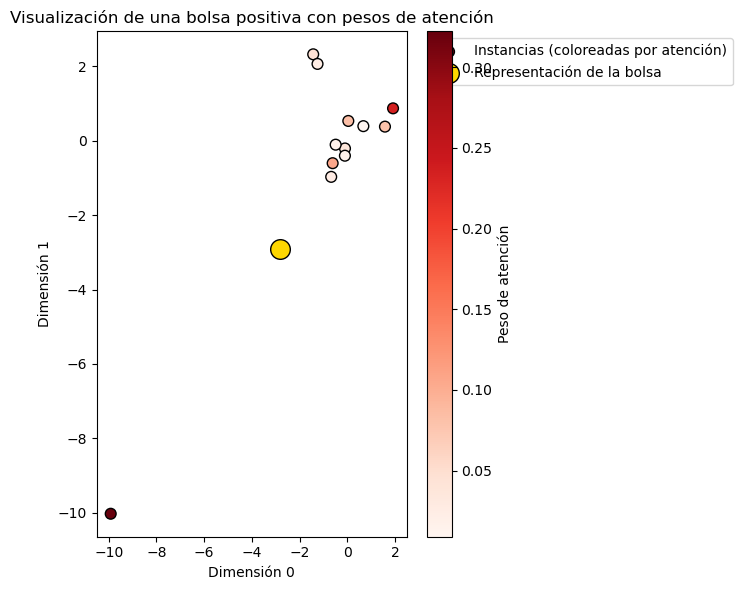

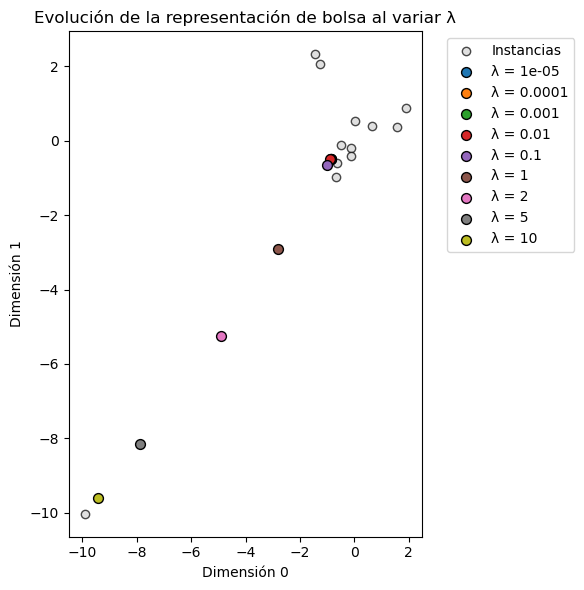

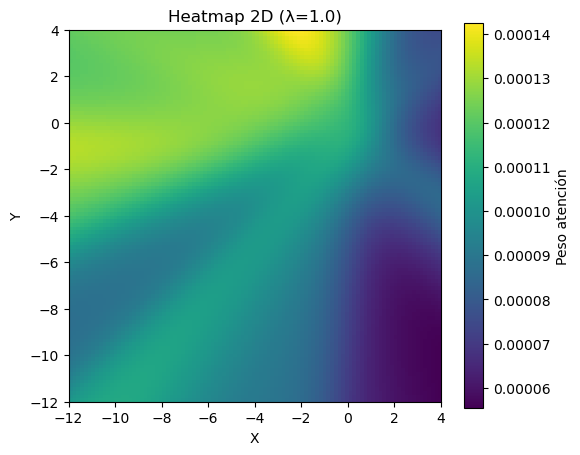

In [ ]:
# -----------------------------------------------------------------------------
#   paint_ds: Usa las funciones definidas arriba
# -----------------------------------------------------------------------------

# 1) Crear loaders
train_loader, test_loader = make_dataloaders(SCStandardMILDataset,
                                            D=128, num_bags=1000, B=10)

# 2) Entrenar y guardar (opcional si ya tienes modelo)
model = train_mil_model(train_loader,
                        feature_dim=128,
                        pooling='attention',
                        lr=1e-3,
                        epochs=3,
                        save_path='models/scstandard/model_attn.pth')

# 3) Evaluar
evaluate_mil_model(model, test_loader)

# 4) OOD scores
compute_ood_scores(model, test_loader)

# 5) Visualizaciones
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LAMBDAS = [0.1, 1, 10] # Valores de λ para la visualización
DIMS   = (0,1)
XRANGE = (-12,4)
YRANGE = (-12,4)

plot_positive_bag_attention(test_loader, model, DEVICE, dims=DIMS)
plot_attention_trajectories(test_loader, model, DEVICE, dims=(0,1))
plot_attention_heatmap_2d(grid_size=100,
                         x_range=XRANGE,
                         y_range=YRANGE,
                         hidden_dim=32,
                         lambda_val=1.0)
